# MPS using the deesse wrapper - simulations with probability constraints

## Main points addressed:
- deesse simulation with probability (proportion) constraints: 
    - categorical or continuous variable
    - local or global probability constraints
    
**Note:** if *global* probability constraints are used and if deesse is launched in parallel (with more than one thread), the reproducibility is not guaranteed.

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=10, micro=6, releaselevel='final', serial=0)
geone version: 1.1.5


## 1. Categorical simulations - global probability constraints

### Training image (TI)
Read the training image. (Source of the image: *D. Allard, D. D'or, and R. Froidevaux, An efficient maximum entropy approach for categorical variable prediction, EUROPEAN JOURNAL OF SOIL SCIENCE, 62(3):381-393, JUN 2011, doi: 10.1111/j.1365-2389.2011.01362.x*)

In [3]:
ti = gn.img.readImageGslib('ti2.gslib')

Plot the image (using the function `geone.imgplot.drawImage2D`).

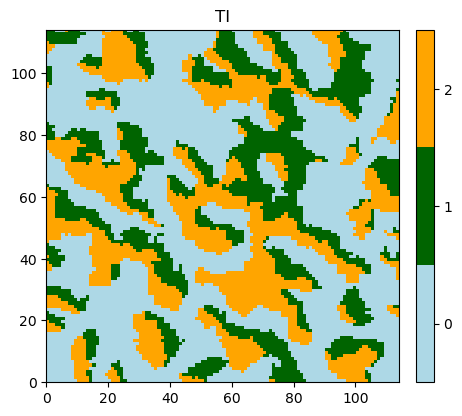

In [4]:
col = ['lightblue', 'darkgreen', 'orange']

plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, categ=True, categCol=col, title='TI')
plt.show()

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [5]:
nx, ny, nz = 300, 300, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Define the classes of values
Set the number of classes, and for each class define the ensemble of values as a (union of) interval(s).

In [6]:
nclass = 3
class1 = [-0.5, 0.5] # interval [-0.5, 0.5[ (for facies code 0)
class2 = [ 0.5, 1.5] # interval [ 0.5, 1.5[ (for facies code 1)
class3 = [ 1.5, 2.5] # interval [ 1.5, 2.5[ (for facies code 2)
# classx = [[-0.5, 0.5],[ 1.5, 2.5]] # for the union [-0.5, 0.5[ U [1.5, 2.5[, containing facies codes 0 and 2
list_of_classes = [class1, class2, class3]

### Define probability constraints (class `geone.deesseinterface.SoftProbability`)
To save time and to avoid noisy simulations, probability constraints can be deactivated when the last pattern node (the farest away from the central cell) is at a distance less than a given value (`deactivationDistance`). Note that the distance is computed according to the units defined for the search neighborhood ellipsoid.

In [7]:
sp = gn.deesseinterface.SoftProbability(
    probabilityConstraintUsage=1,   # global probability constraints
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    globalPdf=[0.2, 0.5, 0.3],      # global target PDF (list of length nclass)
    comparingPdfMethod=5,           # method for comparing PDF's (see doc: help(gn.deesseinterface.SoftProbability))
    deactivationDistance=4.0,       # deactivation distance (checking PDF is deactivated for narrow patterns)
    constantThreshold=1.e-3)        # acceptation threshold

### Fill the input structure for deesse and launch deesse

In [8]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='categ',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete

Warnings encountered (1 times in all):
#  1: WARNING 00111: reproducibility guaranteed when using multiple threads and global probability constraint (performance possibly limited), but results differ from the serial version


### Retrieve the results (and display)

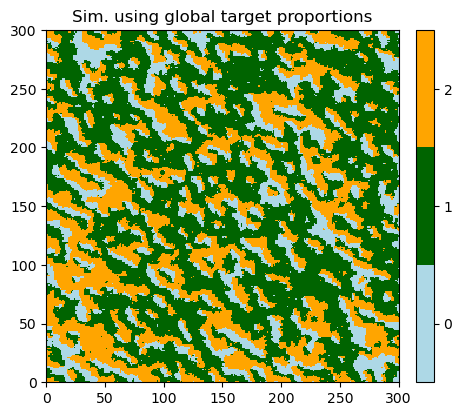

In [9]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(sim[0], categ=True, categCol=col,
                       title='Sim. using global target proportions')
plt.show()

### Compare facies proportions (TI, simulation, target)

In [10]:
ti.get_prop()

[[0.0, 1.0, 2.0], array([[0.51492767, 0.23114805, 0.25392428]])]

In [11]:
sim[0].get_prop() # target proportions are: [0.2, 0.5, 0.3]

[[0.0, 1.0, 2.0], array([[0.19278889, 0.51035556, 0.29685556]])]

## 2. Categorical simulations - local probability constraints

Target proportions can be specified locally. For each cell, target proportions (for each class) in a region around the cell is considered. Hence, proportion maps are required as well as a support radius: the region is defined as the ensemble of the cells in the search neighborhood ellipsoid and at a distance to the central (simulated) cell inferior or equal to the given support radius. Note that the distance are computed according to the units defined for the search neighborhood ellipsoid.

### Build local target proportions maps

In [12]:
# xg, yg: coordinates of the centers of grid cell
xg = ox + 0.5*sx + sx*np.arange(nx)
yg = oy + 0.5*sy + sy*np.arange(ny)
xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Define proportion maps for each class
c = 0.6
p1 = xx + yy     
p1 = c * (p1 - np.min(p1))/ (np.max(p1) - np.min(p1))
p2 = c - p1
p0 = 1.0 - p1 - p2 # constant map (1-c = 0.4)

local_pdf = np.zeros((nclass, nz, ny, nx))
local_pdf[0,0,:,:] = p0
local_pdf[1,0,:,:] = p1
local_pdf[2,0,:,:] = p2

Plot these maps.

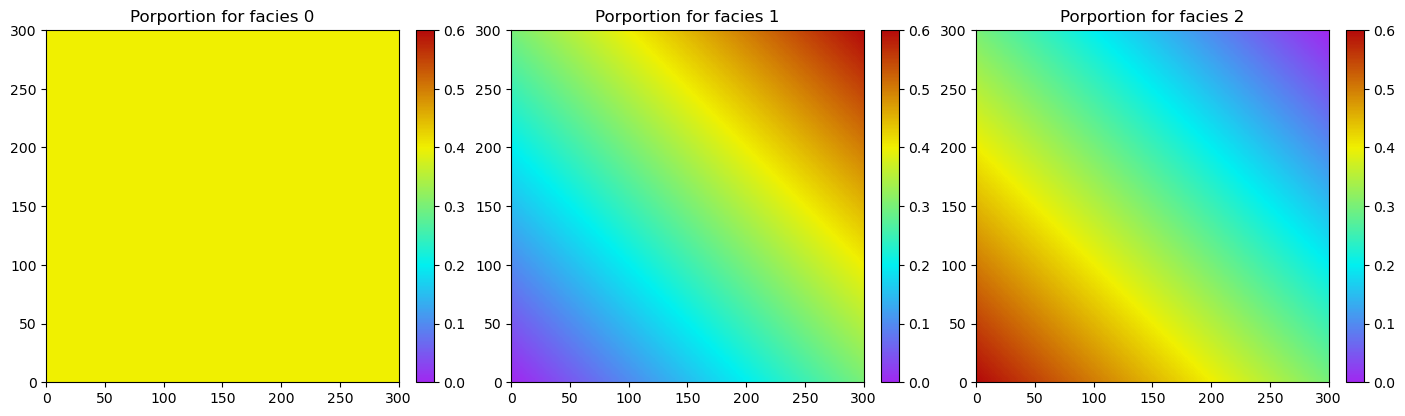

In [13]:
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=3, val=local_pdf)

plt.subplots(1, 3, figsize=(17,5)) # 1 x 3 sub-plots
plt.subplot(1,3,1)
gn.imgplot.drawImage2D(im, iv=0, vmin=0, vmax=c, title='Porportion for facies 0')
plt.subplot(1,3,2)
gn.imgplot.drawImage2D(im, iv=1, vmin=0, vmax=c, title='Porportion for facies 1')
plt.subplot(1,3,3)
gn.imgplot.drawImage2D(im, iv=2, vmin=0, vmax=c, title='Porportion for facies 2')
plt.show()

### Define probability constraints (class `geone.deesseinterface.SoftProbability`)

In [14]:
sp = gn.deesseinterface.SoftProbability(
    probabilityConstraintUsage=2,   # local probability constraints
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    localPdf=local_pdf,             # local target PDF
    localPdfSupportRadius=12.,      # support radius
    comparingPdfMethod=5,           # method for comparing PDF's (see doc: help(gn.deesseinterface.SoftProbability))
    deactivationDistance=4.0,       # deactivation distance (checking PDF is deactivated for narrow patterns)
    constantThreshold=1.e-3)        # acceptation threshold

### Fill the input structure for deesse and launch deesse

In [15]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='categ',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


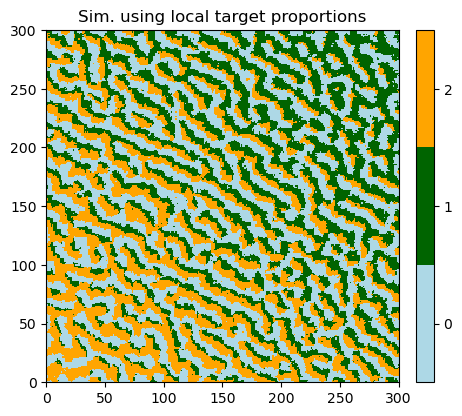

In [16]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(sim[0], categ=True, categCol=col,
                       title='Sim. using local target proportions')
plt.show()

## 2b. Categorical simulations - local probability constraints based on rejection

An alternative to deal with local probability constraints consists in applying rejection. The given probability maps are used to compute rejection probabilities as follows. Note that these maps will not correspond to target proportions. The rejection is applied during the scan of the training image; two rejection modes are available:
- `rejectionMode = 0`: rejection first (before checking pattern (and other constraint)) according to acceptation probabilities proportional to p[i]/q[i] (for class i), where
    - q is the marginal pdf of the scanned training image
    - p is the given local pdf at the simulated node
- `rejectionMode = 1`: rejection last (after checking pattern (and other constraint)) according to acceptation probabilities proportional to p[i] (for class i), where
    - p is the given local pdf at the simulated node 

**Remarks:**
- using `rejectionMode = 0`, the given probability maps would correspond to proportions over an ensemble of realizations if the pattern (and other constraint) was not accounted for, i.e. if random pixels were drawn from the training image and only its marginal proportions mattered.
- using `rejectionMode = 1`, the *pdf* proportional to $q_{MPS}[i] \cdot p[i]$ is sampled, where $q_{MPS}$ denotes the *pdf* resulting from multiple-point statistics (checking pattern (and other constraint)).

### Rejection first ( `rejectionMode = 0`)

#### Define probability constraints (class `geone.deesseinterface.SoftProbability`)

In [17]:
sp = gn.deesseinterface.SoftProbability(
    probabilityConstraintUsage=3,   # local probability constraints based on rejection
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    localPdf=local_pdf,             # local target PDF
    rejectionMode=0,                # rejection first
    deactivationDistance=4.0)       # deactivation distance (checking PDF is deactivated for narrow patterns)

#### Fill the input structure for deesse and launch deesse

In [18]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='categ',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


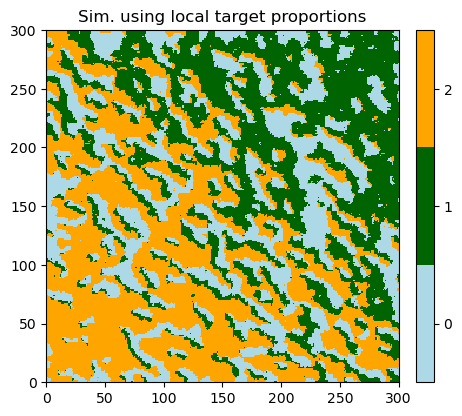

In [19]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(sim[0], categ=True, categCol=col,
                       title='Sim. using local target proportions')
plt.show()

### Rejection last ( `rejectionMode = 1`)

#### Define probability constraints (class `geone.deesseinterface.SoftProbability`)

In [20]:
sp = gn.deesseinterface.SoftProbability(
    probabilityConstraintUsage=3,   # local probability constraints based on rejection
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    localPdf=local_pdf,             # local target PDF
    rejectionMode=1,                # rejection last
    deactivationDistance=4.0)       # deactivation distance (checking PDF is deactivated for narrow patterns)

#### Fill the input structure for deesse and launch deesse

In [21]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='categ',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType='categorical',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.25,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


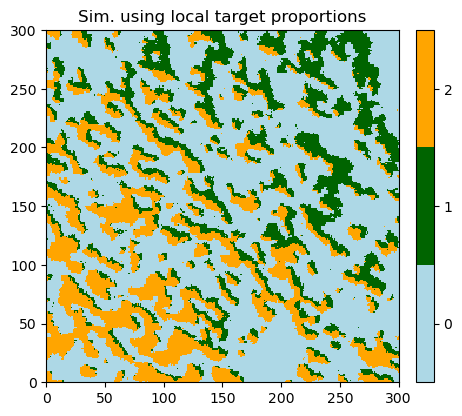

In [22]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(sim[0], categ=True, categCol=col,
                       title='Sim. using local target proportions')
plt.show()

## 3. Continuous simulation - global probability constraints

### Training image (TI)
(Source of the image: *T. Zhang, P. Switzer, and A. Journel, Filter-based classification of training image patterns for spatial simulation, MATHEMATICAL GEOLOGY, 38(1):63-80, JAN 2006, doi: 10.1007/s11004-005-9004-x*)

In [23]:
ti = gn.img.readImageGslib('tiContinuous.gslib')

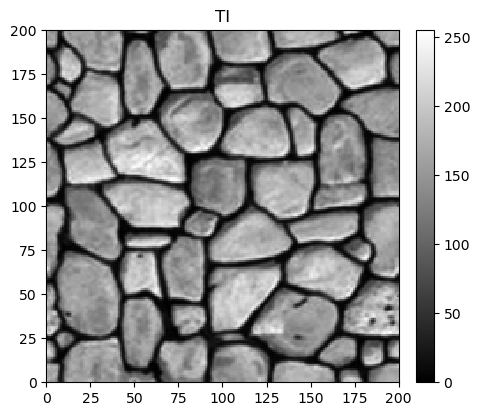

In [24]:
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(ti, cmap=gn.customcolors.cmapB2W, title='TI')
plt.show()

### Simulation grid
Define the simulation grid (number of cells in each direction, cell unit, origin).

In [25]:
nx, ny, nz = 200, 200, 1         # number of cells
sx, sy, sz = ti.sx, ti.sy, ti.sz # cell unit
ox, oy, oz = 0.0, 0.0, 0.0       # origin (corner of the "first" grid cell)

### Define the classes of values
Set the number of classes, and for each class define the ensemble of values as a (union of) interval(s).

In [26]:
vmin, vmax = 0., 256.
nclass = 10
breaks = np.linspace(vmin, vmax, nclass+1)
list_of_classes = [np.array([[breaks[i], breaks[i+1]]]) for i in range(nclass)]

### Define probability constraints (class `geone.deesseinterface.SoftProbability`)

In [27]:
global_pdf = np.repeat(1./nclass, nclass) # global pdf (proportion for each class), uniform

sp = gn.deesseinterface.SoftProbability(
    probabilityConstraintUsage=1,   # global probability constraints
    nclass=nclass,                       # number of classes of values
    classInterval=list_of_classes,  # list of classes
    globalPdf=global_pdf,           # global target PDF (list of length nclass)
    comparingPdfMethod=5,           # method for comparing PDF's (see doc: help(gn.deesseinterface.SoftProbability))
    deactivationDistance=2.0,       # deactivation distance (checking PDF is deactivated for narrow patterns)
    constantThreshold=0)            # acceptation threshold

### Fill the input structure for deesse and launch deesse

In [28]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    softProbability=sp,       # set probability constraints
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.5,
    npostProcessingPathMax=0, # disable post-processing (to avoid loosing target proportions)
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete

Warnings encountered (1 times in all):
#  1: WARNING 00111: reproducibility guaranteed when using multiple threads and global probability constraint (performance possibly limited), but results differ from the serial version


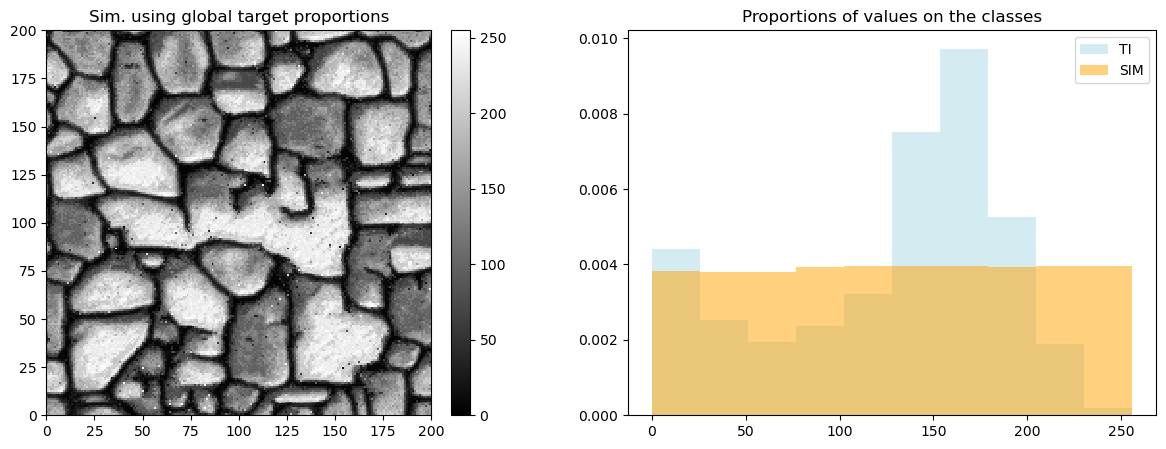

In [29]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.subplots(1,2, figsize=(15,5)) # 1 x 2 sub-plots

plt.subplot(1,2,1)
gn.imgplot.drawImage2D(sim[0], cmap=gn.customcolors.cmapB2W,
                       title='Sim. using global target proportions')

plt.subplot(1,2,2)
plt.hist(ti.val.reshape(-1), bins=breaks, density=True, color='lightblue', alpha=0.5, label='TI')
plt.hist(sim[0].val.reshape(-1), bins=breaks, density=True, color='orange', alpha=0.5, label='SIM')
plt.legend()
plt.title('Proportions of values on the classes')

plt.show()

## 4. Continuous simulations - local probability constraints

### Define new classes of values

In [30]:
nclass = 2
class1 = [0., 50.]   # interval [0., 50.[ (low values)
class2 = [50., 256.] # interval [50., 256.[ (high values)
list_of_classes = [class1, class2]

### Build local target proportions maps

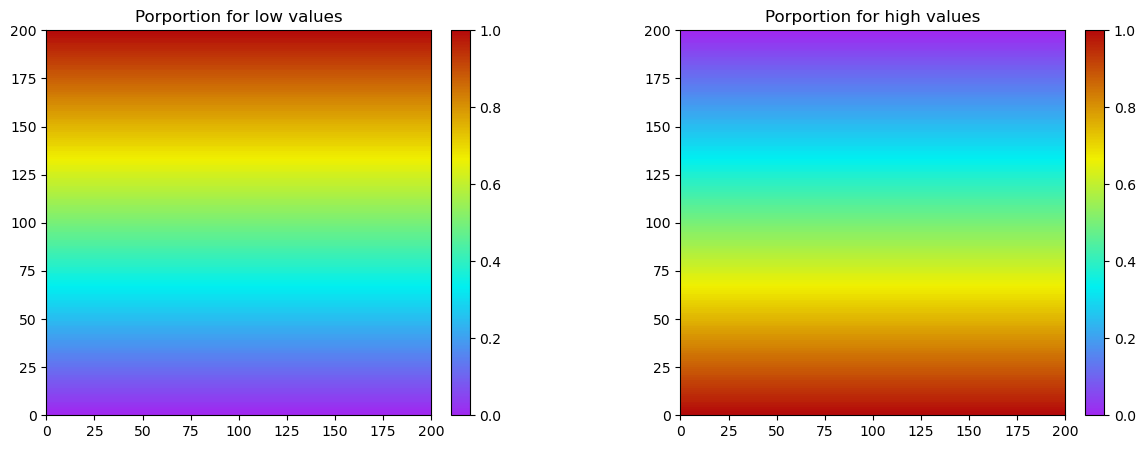

In [31]:
# xg, yg: coordinates of the centers of grid cell
xg = ox + 0.5*sx + sx*np.arange(nx)
yg = oy + 0.5*sy + sy*np.arange(ny)
xx, yy = np.meshgrid(xg, yg) # create meshgrid from the center of grid cells

# Define proportion maps for each class
p0 = (yy - np.min(yy))/ (np.max(yy) - np.min(yy))
p1 = 1.0 - p0

local_pdf = np.zeros((nclass, nz, ny, nx))
local_pdf[0,0,:,:] = p0
local_pdf[1,0,:,:] = p1

# Plot these maps
im = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=2, val=local_pdf)

plt.subplots(1, 2, figsize=(15,5)) # 1 x 2 sub-plots
plt.subplot(1,2,1)
gn.imgplot.drawImage2D(im, iv=0, vmin=0, vmax=1, title='Porportion for low values')
plt.subplot(1,2,2)
gn.imgplot.drawImage2D(im, iv=1, vmin=0, vmax=1, title='Porportion for high values')
plt.show()

### Define probability constraints (class `geone.deesseinterface.SoftProbability`)

In [32]:
sp = gn.deesseinterface.SoftProbability(
    probabilityConstraintUsage=2,   # local probability constraints
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    localPdf=local_pdf,             # local target PDF
    localPdfSupportRadius=12.,      # support radius
    comparingPdfMethod=5,           # method for comparing PDF's (see doc: help(gn.deesseinterface.SoftProbability))
    deactivationDistance=4.0,       # deactivation distance (checking PDF is deactivated for narrow patterns)
    constantThreshold=0.001)        # acceptation threshold

### Fill the input structure for deesse and launch deesse

In [33]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.5,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


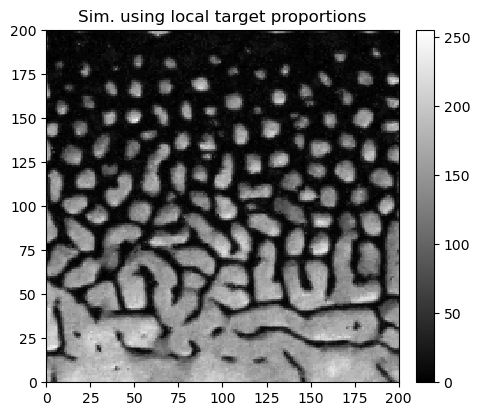

In [34]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(sim[0], cmap=gn.customcolors.cmapB2W,
                       title='Sim. using local target proportions')
plt.show()

## 4b. Continuous simulations - local probability constraints based on rejection

### Rejection first ( `rejectionMode = 0`)

#### Define probability constraints (class `geone.deesseinterface.SoftProbability`)

In [35]:
sp = gn.deesseinterface.SoftProbability(
    probabilityConstraintUsage=3,   # local probability constraints based on rejection
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    localPdf=local_pdf,             # local target PDF
    rejectionMode=0,                # rejection first
    deactivationDistance=4.0)       # deactivation distance (checking PDF is deactivated for narrow patterns)

#### Fill the input structure for deesse and launch deesse

In [36]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.5,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


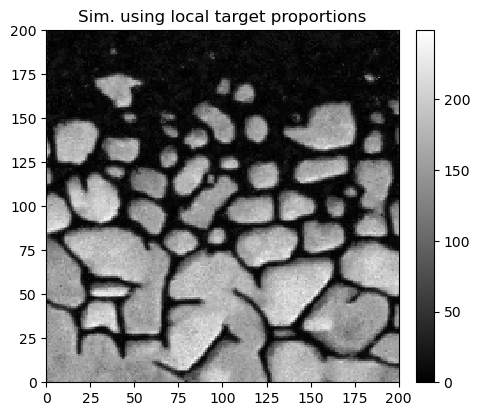

In [37]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(sim[0], cmap=gn.customcolors.cmapB2W,
                       title='Sim. using local target proportions')
plt.show()

### Rejection last ( `rejectionMode = 1`)

#### Define probability constraints (class `geone.deesseinterface.SoftProbability`)

In [38]:
sp = gn.deesseinterface.SoftProbability(
    probabilityConstraintUsage=3,   # local probability constraints based on rejection
    nclass=nclass,                  # number of classes of values
    classInterval=list_of_classes,  # list of classes
    localPdf=local_pdf,             # local target PDF
    rejectionMode=1,                # rejection last
    deactivationDistance=4.0)       # deactivation distance (checking PDF is deactivated for narrow patterns)

#### Fill the input structure for deesse and launch deesse

In [39]:
nreal = 1
deesse_input = gn.deesseinterface.DeesseInput(
    nx=nx, ny=ny, nz=nz,
    sx=sx, sy=sy, sz=sz,
    ox=ox, oy=oy, oz=oz,
    nv=1, varname='code',
    nTI=1, TI=ti,
    softProbability=sp,      # set probability constraints
    distanceType='continuous',
    nneighboringNode=24,
    distanceThreshold=0.05,
    maxScanFraction=0.5,
    npostProcessingPathMax=1,
    seed=444,
    nrealization=nreal)

deesse_output = gn.deesseinterface.deesseRun(deesse_input)

DeeSse running... [VERSION 3.2 / BUILD NUMBER 20221014 / OpenMP 19 thread(s)]
* checking out license OK.
DeeSse run complete


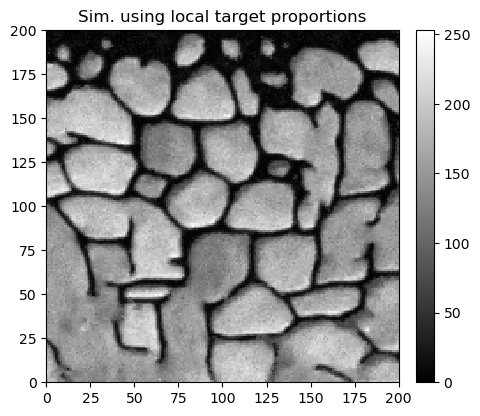

In [40]:
# Retrieve the realization
sim = deesse_output['sim']

# Display
plt.figure(figsize=(5,5))
gn.imgplot.drawImage2D(sim[0], cmap=gn.customcolors.cmapB2W,
                       title='Sim. using local target proportions')
plt.show()